In [1]:
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader, Dataset
import torch

import sys
sys.path.append('../')
import os

from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config
from correlation_metrics import register_act, plot_metrics

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
data_dir = "/home/ec2-user/nta/data/data_classes/"
test_dir = "/home/ec2-user/nta/data/"
config_file = "../experiments.cfg"

odcorrs, dcorrs = [], []
oddotproducts, ddotproducts = [], []
shodcorrs, shdcorrs = [], []
shoddotproducts, shddotproducts = [], []

for exp in ["denseCNN2", "sparseCNN2"]:
    config_init = parse_config(config_file)
    config = config_init[exp]
    config["name"] = exp
    config["seed"] = np.random.randint(0,200)
    config["data_dir"] = data_dir
    config["batch_size"] = 32
    config["num_classes"] = 11

    config["freeze_params"] = [] 

    experiment = ContinuousSpeechExperiment(config=config)

    for epoch in range(1):
        experiment.train_entire_dataset(epoch)
        
    t = experiment.test()
    print("Mean accuracy: {}".format(t["mean_accuracy"]))

    corrs, shuffled_corrs = register_act(experiment)

    offdiag_corrs, diag_corrs, offdiag_dotprods, diag_dotprods = corrs
    sh_offdiag_corrs, sh_diag_corrs, sh_offdiag_dotprods, sh_diag_dotprods = shuffled_corrs
    
    odcorrs.append(offdiag_corrs)
    dcorrs.append(diag_corrs)
    oddotproducts.append(offdiag_dotprods)
    ddotproducts.append(diag_dotprods)
    
    shodcorrs.append(sh_offdiag_corrs)
    shdcorrs.append(sh_diag_corrs)
    shoddotproducts.append(sh_offdiag_dotprods)
    shddotproducts.append(sh_diag_dotprods)

model on GPU
Creating optimizer with learning rate= 0.01
Mean accuracy: 67.59404388714734
model on GPU
Creating optimizer with learning rate= 0.01
Mean accuracy: 85.38401253918495


In [2]:
import time

class SparseCorrExperiment(object):
    def __init__(self, config_file):
        self.dense_network = "denseCNN2"
        self.sparse_network = "sparseCNN2"
        self.default_cnn_size = 64
        self.config_init = parse_config(config_file)
        
    def layer_size_comparison(self, layer_sizes, plot_results=True, freeze_linear=False, shuffled=False):
        sparse_factor = [layer_sizes[0]/k for k in layer_sizes]
        curr_sparsity = self.config_init["sparseCNN2"]["cnn_weight_sparsity"]
        curr_percent_on = self.config_init["sparseCNN2"]["cnn_percent_on"]
        
        odcorrs, dcorrs = [], []
        oddotproducts, ddotproducts = [], []
        output = [odcorrs, dcorrs, oddotproducts, ddotproducts]
        
        if shuffled:
            shodcorrs, shdcorrs = [], []
            shoddotproducts, shddotproducts = [], []
            sh_output = [shodcorrs, shdcorrs, shoddotproducts, shddotproducts]
            
        for exp in [self.dense_network, self.sparse_network]:
            for ind in range(len(layer_sizes)):
                config = self.config_init[exp]
                config["name"] = exp
                
                if freeze_linear:
                    config["freeze_params"] = "output"
                else:
                    config["freeze_params"] = []
                    
                config["cnn_out_channels"] = (layer_sizes[ind], layer_sizes[ind])
                config["cnn_weight_sparsity"] = (curr_sparsity[0]*sparse_factor[ind], curr_sparsity[1]*sparse_factor[ind])
                config["cnn_percent_on"] = (curr_percent_on[0]*sparse_factor[ind], curr_percent_on[1]*sparse_factor[ind])
    
                outputs = self.run_experiment(config, layer_sizes[ind], shuffled=shuffled)
                if shuffled:
                    [output[k].append(outputs[k]) for k in range(len(outputs[0]))]                    
                    [sh_output[k].append(sh_outputs[k]) for k in range(len(outputs[1]))]
                else:
                    [output[k].append(outputs[k]) for k in range(len(outputs))]                    

        if shuffled:
            return output, sh_output
        else:
            return output
        
    def run_experiment(self, config, layer_size, shuffled=False):
        experiment = ContinuousSpeechExperiment(config=config)
        start_time = time.time()
        experiment.train_entire_dataset(0)
        end_time = np.round(time.time() - start_time, 3)
        print("{} layer size network trained in {} s".format(layer_size, end_time))

        if shuffled:
            corrs, shuffled_corrs = register_act(experiment)
            return corrs, shuffled_corrs
        else:
            corrs = register_act(experiment)                    
            return corrs                
        

In [3]:
experiment = SparseCorrExperiment(config_file = "../experiments.cfg")

In [4]:
dotprod_results = experiment.layer_size_comparison([64, 128, 256])

Creating optimizer with learning rate= 0.01
64 layer size network trained in 6.784 s
Creating optimizer with learning rate= 0.01
128 layer size network trained in 11.074 s
Creating optimizer with learning rate= 0.01
256 layer size network trained in 26.328 s
Creating optimizer with learning rate= 0.01
64 layer size network trained in 11.154 s
Creating optimizer with learning rate= 0.01
128 layer size network trained in 17.866 s
Creating optimizer with learning rate= 0.01
256 layer size network trained in 36.168 s


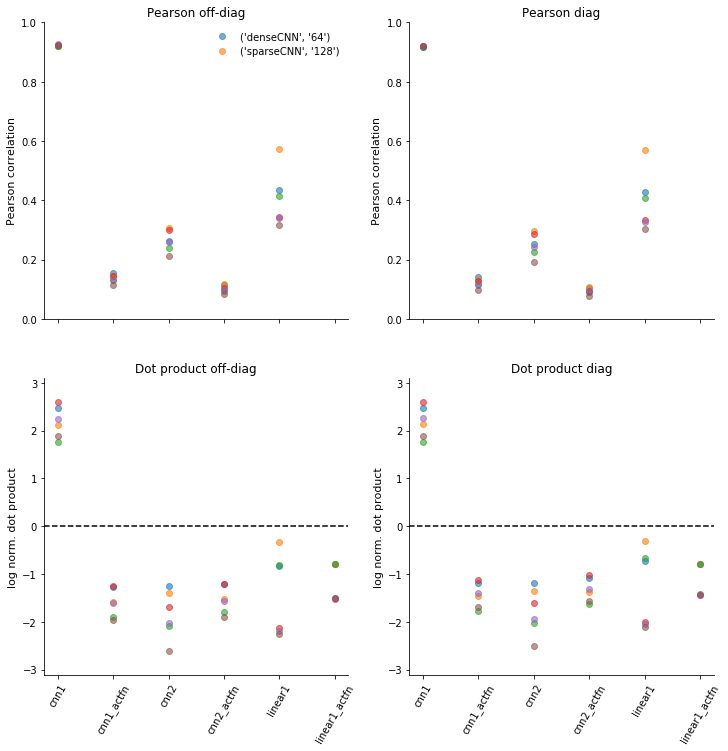

In [79]:

plot_metrics(dotprod_results, legend_=leg)

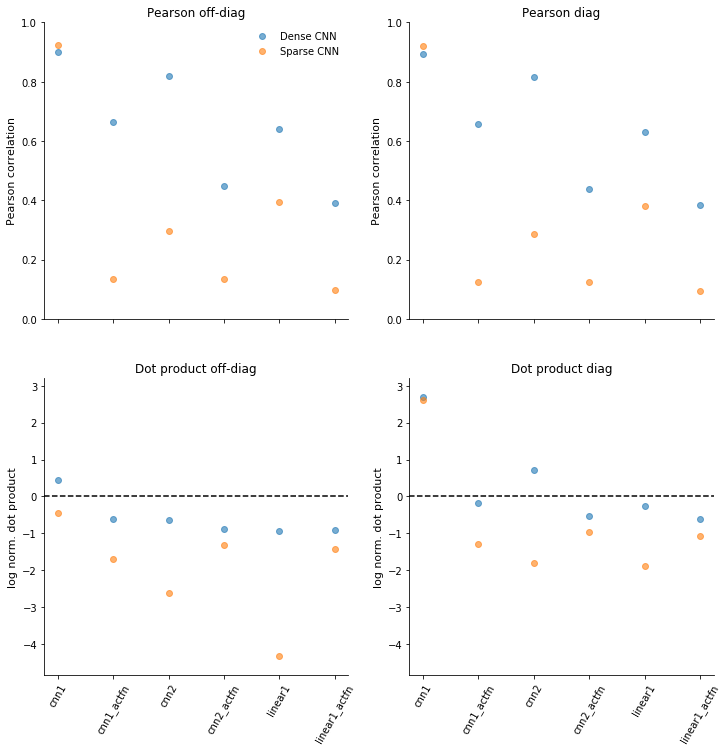

In [42]:
metrics = [shodcorrs, shdcorrs, shoddotproducts, shddotproducts]
plot_metrics(metrics)

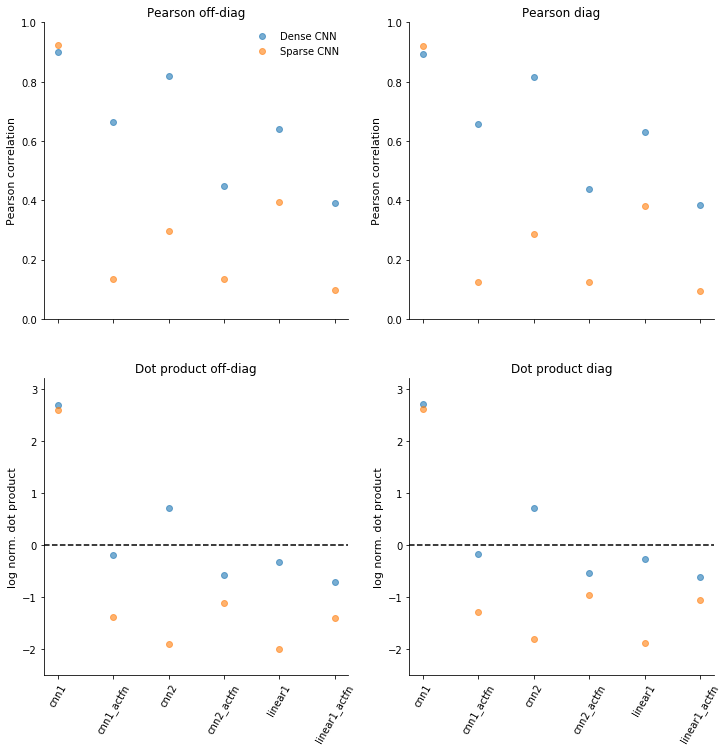

In [43]:
metrics = [odcorrs, dcorrs, oddotproducts, ddotproducts]
plot_metrics(metrics)

In [27]:
np.log(1e-4)

-9.210340371976182

In [45]:
array_ = np.hstack([acts[0][k]['linear1_relu'] for k in range(10)])
array = array_.reshape(32,np.prod(array_.shape[1:]))

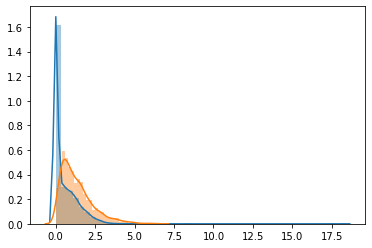

In [64]:
sns.distplot(array[0,:], kde=True)
sns.distplot(np.random.gamma(1.7, 0.8, 2000))

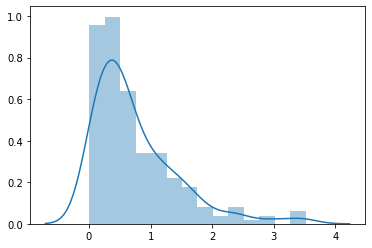

In [57]:
sns.distplot(np.random.gamma(1., 0.8, 200))

In [65]:
v1 = []
for j in range(10):
    a = np.zeros((32*64))
    inds = np.random.randint(a.size, size=int(a.size / 2))
    a[inds] = np.random.gamma(1.7, 0.8)
    v1.append(a.reshape(32,64))

In [52]:
v2 = []
for j in range(10):
    b = np.zeros((32*64))
    inds = np.random.randint(b.size, size=int(b.size / 2))
    b[inds] = 1.
    v2.append(b.reshape(32,64))

In [86]:
def random_dotprods(m,n,sparsity=0.1, iters=100):

    v1 = []
    for j in range(10):
        a = np.zeros((m*n))
        inds = np.random.randint(a.size, size=int(sparsity*a.size))
        a[inds] = np.random.gamma(1.7, 0.8)
        v1.append(a.reshape(m,n) + 1e-5)#+ 1e-9*np.random.rand(m,n))
        iu = np.triu_indices(10,1)

    def get_dotprod():
        dot_mat = np.zeros((10,10))
        corr_mat = np.zeros_like(dot_mat)
        for i in range(10):
            for j in range(10):
                corr_mat[i,j] = np.mean(np.corrcoef(v1[i],
                                                   v1[j])[iu])
                dot_mat[i,j] = np.mean([np.dot(v1[i][x,:],
                                               v1[j][y,:]) / n
                                      for x in range(m)
                                        for y in range(m)
                                       ])
        return dot_mat, corr_mat
    
    dp_ = [get_dotprod()[k][iu].flatten().mean() for k in range(2) for i in range(iters)]
    dp_mean, cc_mean = np.mean(dp_[::2]), np.mean(dp_[1::2])

    
    return dp_mean, cc_mean

In [87]:
dps = [random_dotprods(32,64, sparsity=k, iters=100) for k in np.arange(0.0,1.0, 0.05)]

/home/ec2-user/miniconda3/envs/nupic.research/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ec2-user/miniconda3/envs/nupic.research/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


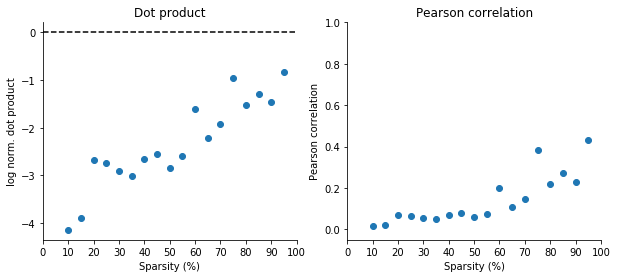

In [89]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(np.arange(0.00,1.0, 0.05), [np.log(k[0]) for k in dps], 'o')
ax[0].set_xticks(np.arange(0.0, 1.1, 0.1));
ax[0].set_xticklabels(np.int8(np.arange(0.0, 1.1, 0.1)*100))
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_title("Dot product")
ax[0].set_xlabel("Sparsity (%)")
ax[0].set_ylabel("log norm. dot product")
ax[0].axhline([0], color="k", linestyle="--")
# ax[0].set_ylim((-9.5, 1.))

ax[1].plot(np.arange(0.00,1.0, 0.05), [k[1] for k in dps], 'o')
ax[1].set_xticks(np.arange(0.0, 1.1, 0.1));
ax[1].set_xticklabels(np.int8(np.arange(0.0, 1.1, 0.1)*100))
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].set_title("Pearson correlation")
ax[1].set_xlabel("Sparsity (%)")
ax[1].set_ylabel("Pearson correlation")
ax[1].set_ylim((-0.05, 1.));

plt.savefig("../plots/random_sparse_vectors_corr_metrics_32_64_beta_17_08.pdf")

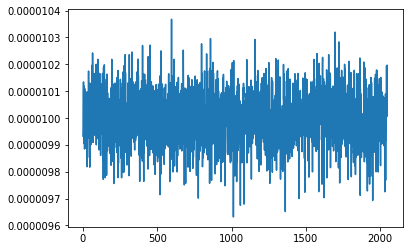

In [150]:
plt.plot(1e-5 + 1e-7*np.random.randn(a.size))

In [73]:
int(np.arange(10))

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
1